# Ontario Historical and Live Energy Generations Pricing
## Based on IESO data
Need to get a sense of the historical Energy pricing data and figure out methods of controlling energy arbitrage based on live data. Also can produce simulations based on historical data.

Start with the IESO Hourly Pricing data: https://www.ieso.ca/Power-Data/Data-Directory
http://reports.ieso.ca/public/PriceHOEPPredispOR/

Plotting 2024 current data

Plotting 2023 Data

Lets take 2021-2023 data together to build a relational model for simulation. 

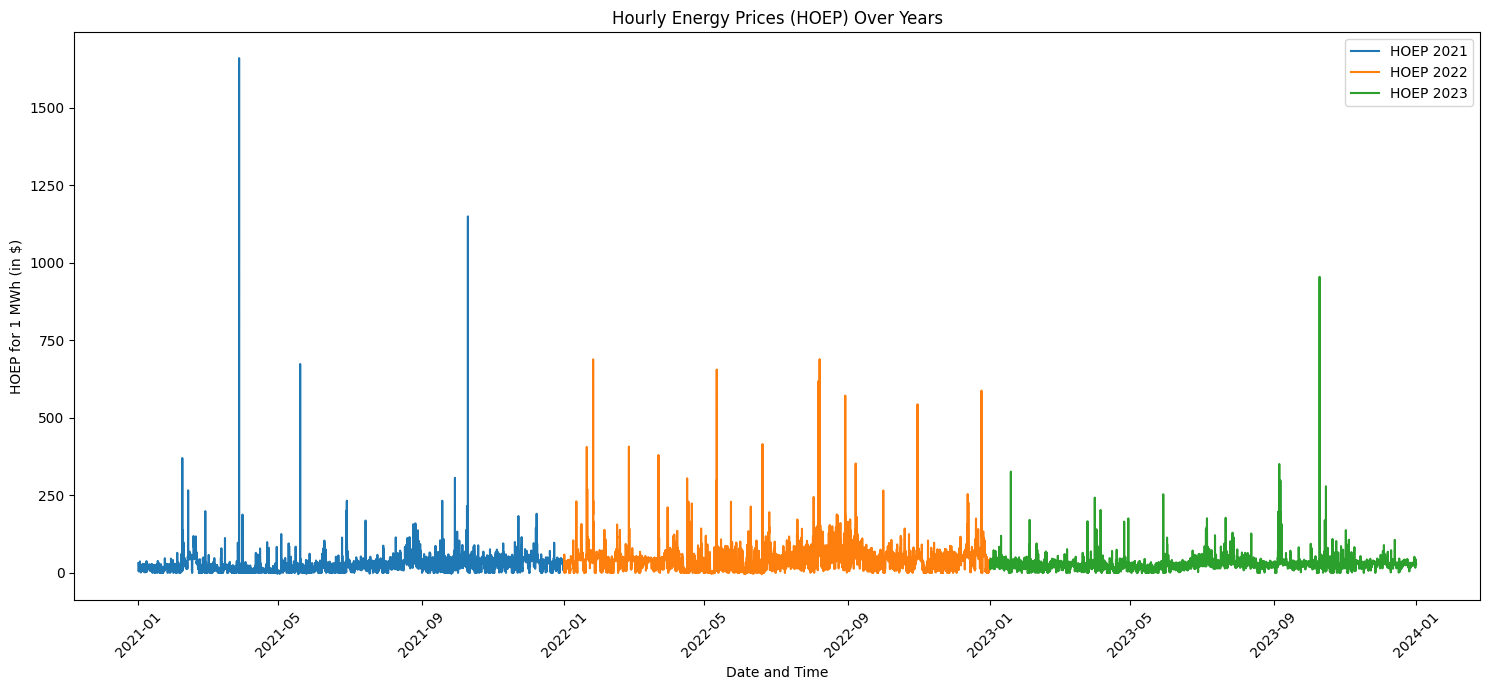

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File paths for each year's CSV data
file_paths = {
    '2021': './Pricing_Data/PUB_PriceHOEPPredispOR_2021_v395.csv',
    '2022': './Pricing_Data/PUB_PriceHOEPPredispOR_2022_v396.csv',
    '2023': './Pricing_Data/PUB_PriceHOEPPredispOR_2023_v393.csv'
}

# Initialize a figure for plotting
plt.figure(figsize=(15, 7))

# Loop through each file path and plot the data
for year, file_path in file_paths.items():
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Clean and prepare the data
    data = data.iloc[2:]  # Skip the first two rows of header information
    data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    data = data[['Date', 'Hour', 'HOEP']].reset_index(drop=True)
    data = data[data['Hour'].str.isnumeric()]  # Filter out non-numeric rows
    data['Hour'] = data['Hour'].astype(int) - 1  # Adjust hour to 0-23 format
    data['Datetime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
    data['HOEP'] = pd.to_numeric(data['HOEP'], errors='coerce')
    data.dropna(subset=['HOEP'], inplace=True)

    # Plot the data
    plt.plot(data['Datetime'], data['HOEP'], label=f'HOEP {year}')

# Add title, labels, and legend
plt.title('Hourly Energy Prices (HOEP) Over Years')
plt.xlabel('Date and Time')
plt.ylabel('HOEP for 1 MWh (in $)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Need to get a sense for the average daily flucation in pricing.


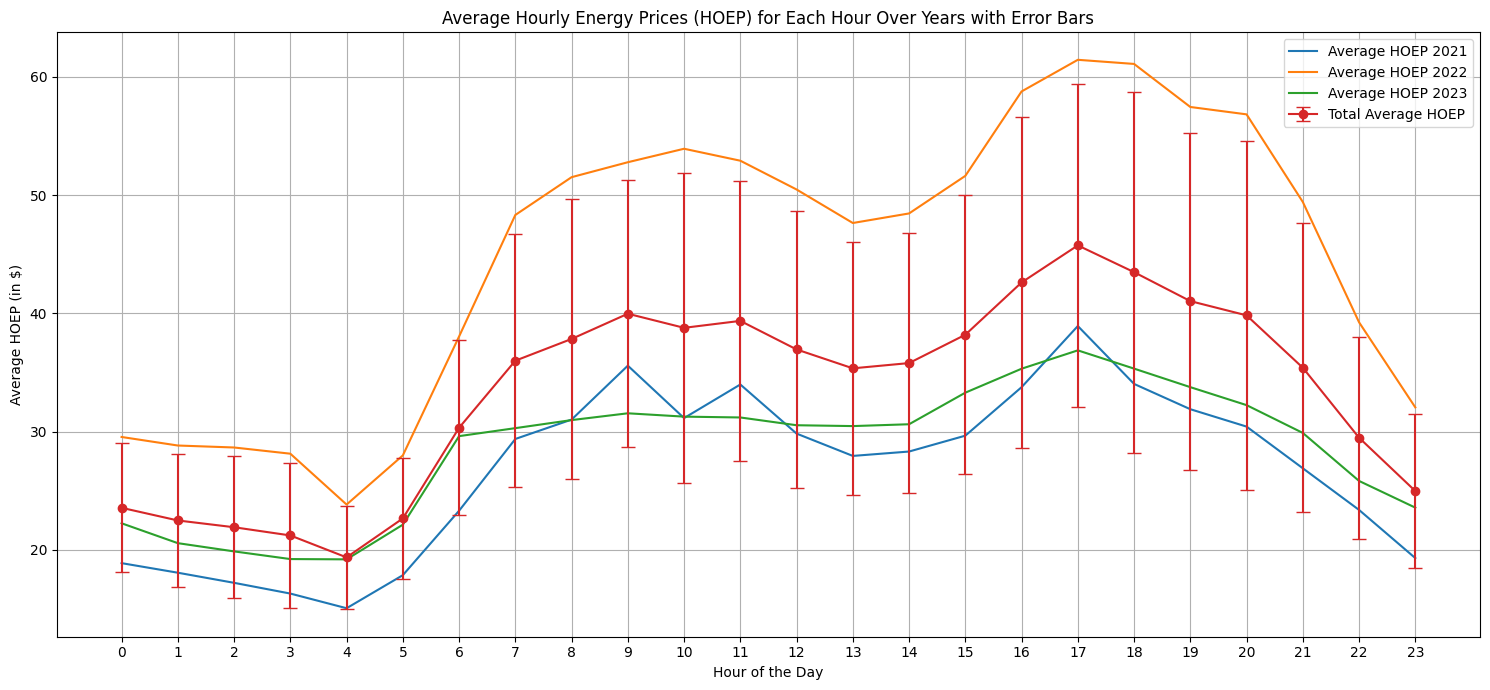

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the file paths


# Initialize a list to hold dataframes of hourly averages for each year
hourly_avg_all_years = []

# Initialize a figure for plotting
plt.figure(figsize=(15, 7))

# Process each file
for year, file_path in file_paths.items():
    # Load the data
    data = pd.read_csv(file_path, skiprows=2)

    # Rename columns for consistency and clarity
    data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    data = data[['Date', 'Hour', 'HOEP']]

    # Remove any non-numeric rows from 'Hour' column to prevent errors during type conversion
    data = data[data['Hour'].apply(lambda x: x.isnumeric())]
    
    # Convert the 'Hour' to an integer type
    data['Hour'] = data['Hour'].astype(int) - 1  # Adjusting for 0-23 hour format

    # Convert 'Date' to datetime and 'HOEP' to numeric values
    data['HOEP'] = pd.to_numeric(data['HOEP'], errors='coerce')

    # Drop rows with any null/NaN values in 'HOEP'
    data = data.dropna(subset=['HOEP'])

    # Group by 'Hour' and calculate the average 'HOEP' for each hour
    hourly_avg = data.groupby('Hour')['HOEP'].mean().reset_index()
    
    # Append the yearly average to the list
    hourly_avg_all_years.append(hourly_avg.set_index('Hour'))
    
    # Plot the average hourly prices for each year
    plt.plot(hourly_avg['Hour'], hourly_avg['HOEP'], label=f'Average HOEP {year}')

# Concatenate the list of DataFrames into one DataFrame for combined statistics
combined_hourly_avg = pd.concat(hourly_avg_all_years, axis=1)
# Calculate the mean and standard deviation across the years for each hour
combined_hourly_mean = combined_hourly_avg.mean(axis=1)
combined_hourly_std = combined_hourly_avg.std(axis=1)

# Plot the mean values with error bars
plt.errorbar(combined_hourly_mean.index, combined_hourly_mean, yerr=combined_hourly_std, label='Total Average HOEP', fmt='-o', capsize=5)

# Add title, labels, and legend to the plot
plt.title('Average Hourly Energy Prices (HOEP) for Each Hour Over Years with Error Bars')
plt.xlabel('Hour of the Day')
plt.ylabel('Average HOEP (in $)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-ticks to show every hour of the day
plt.tight_layout()

# Show the plot
plt.show()


Energy arbitrage optimal to 4MWh storage:
Assumptions:

The battery system has a fixed capacity (e.g., 100 MWh) and starts each simulation fully charged.
The battery has a fixed charge and discharge rate (e.g., 10 MW/h).
The battery has perfect efficiency (no energy loss during charge/discharge, though in reality this is not the case).
The algorithm will not consider grid constraints or additional costs such as wear and tear.
Energy can be bought at any hour's HOEP and sold at any hour's HOEP.
There are no transaction costs for buying or selling energy.
The decision to charge or discharge is based solely on the current hour's price compared to the next hour's predicted price.
The prediction for the next hour's price is the simple average of the past 24 hours' prices.
Algorithm:

Charge: If the current price is lower than the predicted price for the next hour, and the battery is not fully charged, buy and store energy.
Discharge (Sell): If the current price is higher than the predicted price for the next hour, and the battery has stored energy, sell energy.
Hold: If the current price is equal to the predicted price, do nothing.

## test with 24 hour moving average

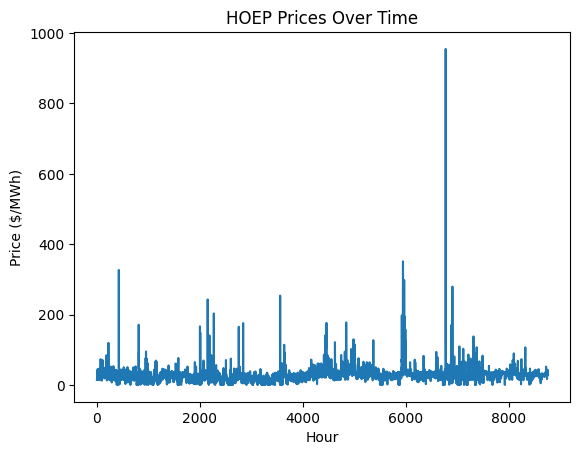

Total profit from energy arbitrage over the simulation period: $22175.54


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths for each year's CSV data
file_paths = {

    '2023': './Pricing_Data/PUB_PriceHOEPPredispOR_2023_v393.csv'
}

# Parameters
battery_capacity = 4  # MWh
battery_charge_rate = 1  # MW/h, also discharge rate
battery_state = battery_capacity  # Battery starts fully charged


# Combine all years of data into a single DataFrame
all_data = pd.DataFrame()
for file_path in file_paths.values():
    yearly_data = pd.read_csv(file_path, skiprows=2)
    yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
    yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
    yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
    all_data = pd.concat([all_data, yearly_data])

# Clean the data and reset index
all_data.reset_index(drop=True, inplace=True)
all_data.dropna(subset=['HOEP'], inplace=True)

# Simulation
profit = 0
energy_stored = 0
hourly_hoep = all_data['HOEP'].values

for i in range(24, len(hourly_hoep)-1):
    # Predict the next hour price as the average of the last 24 hours
    predicted_next_hour_price = np.mean(hourly_hoep[i-24:i])
    current_price = hourly_hoep[i]

    # Decision to buy/sell/hold
    if current_price < predicted_next_hour_price and energy_stored < battery_capacity:
        # Buy energy to store
        energy_to_buy = min(battery_charge_rate, battery_capacity - energy_stored)
        energy_stored += energy_to_buy
        profit -= energy_to_buy * current_price
    elif current_price > predicted_next_hour_price and energy_stored > 0:
        # Sell stored energy
        energy_to_sell = min(battery_charge_rate, energy_stored)
        energy_stored -= energy_to_sell
        profit += energy_to_sell * current_price

# Plotting the results
plt.plot(all_data['HOEP'])
plt.title('HOEP Prices Over Time')
plt.xlabel('Hour')
plt.ylabel('Price ($/MWh)')
plt.show()

print(f"Total profit from energy arbitrage over the simulation period: ${profit:.2f}")


## Test with the given 1 hour predictions

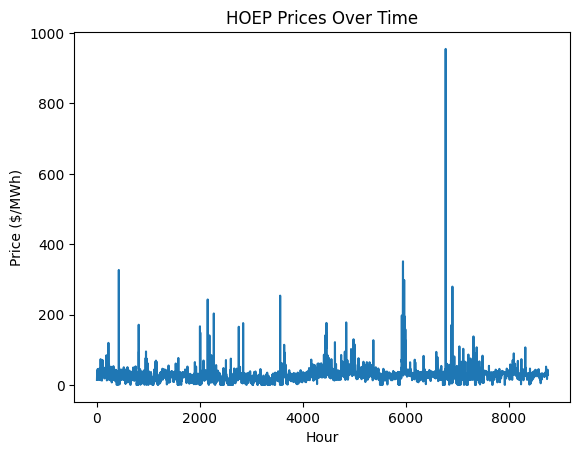

Total profit from energy arbitrage over the simulation period: $13832.87


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Parameters
battery_capacity = 4  # MWh
battery_charge_rate = 1  # MW/h, also discharge rate
battery_state = battery_capacity  # Battery starts fully charged

# Combine all years of data into a single DataFrame
all_data = pd.DataFrame()
for file_path in file_paths.values():
    yearly_data = pd.read_csv(file_path, skiprows=2)
    yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    yearly_data = yearly_data[['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch']]
    yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
    yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
    yearly_data['Hour 1 Predispatch'] = pd.to_numeric(yearly_data['Hour 1 Predispatch'], errors='coerce')
    all_data = pd.concat([all_data, yearly_data])

# Clean the data and reset index
all_data.reset_index(drop=True, inplace=True)
all_data.dropna(subset=['HOEP', 'Hour 1 Predispatch'], inplace=True)

# Simulation
profit = 0
energy_stored = 0
hourly_hoep = all_data['HOEP'].values
predicted_hour_price = all_data['Hour 1 Predispatch'].values

for i in range(len(hourly_hoep)-1):
    current_price = hourly_hoep[i]
    predicted_next_hour_price = predicted_hour_price[i]

    # Decision to buy/sell/hold
    if current_price < predicted_next_hour_price and energy_stored < battery_capacity:
        # Buy energy to store
        energy_to_buy = min(battery_charge_rate, battery_capacity - energy_stored)
        energy_stored += energy_to_buy
        profit -= energy_to_buy * current_price
    elif current_price > predicted_next_hour_price and energy_stored > 0:
        # Sell stored energy
        energy_to_sell = min(battery_charge_rate, energy_stored)
        energy_stored -= energy_to_sell
        profit += energy_to_sell * current_price

# Plotting the results
plt.plot(all_data['HOEP'])
plt.title('HOEP Prices Over Time')
plt.xlabel('Hour')
plt.ylabel('Price ($/MWh)')
plt.show()

print(f"Total profit from energy arbitrage over the simulation period: ${profit:.2f}")


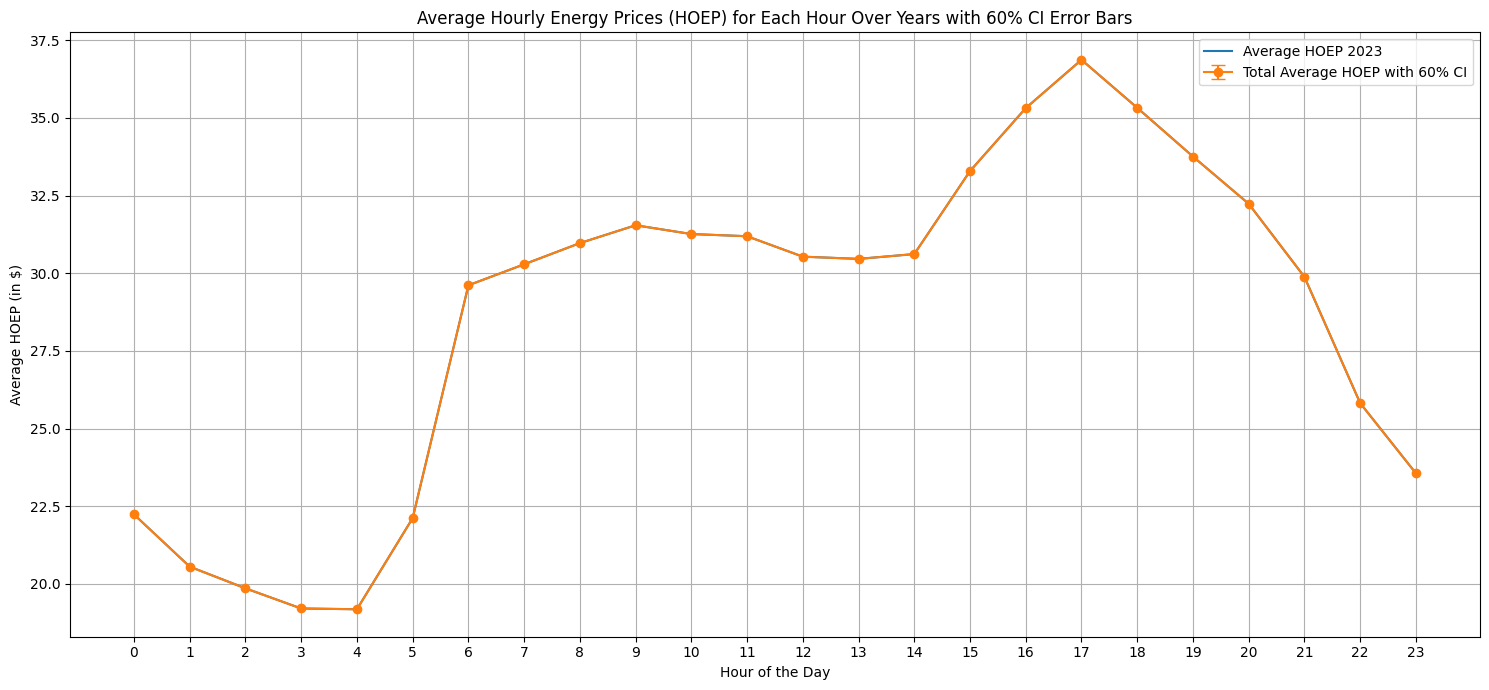

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Initialize a list to hold dataframes of hourly averages for each year
hourly_avg_all_years = []

# Initialize a figure for plotting
plt.figure(figsize=(15, 7))

# Process each file
for year, file_path in file_paths.items():
    # Load the data
    data = pd.read_csv(file_path, skiprows=2)

    # Rename columns for consistency and clarity
    data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    data = data[['Date', 'Hour', 'HOEP']]

    # Remove any non-numeric rows from 'Hour' column to prevent errors during type conversion
    data = data[data['Hour'].apply(lambda x: x.isnumeric())]
    
    # Convert the 'Hour' to an integer type
    data['Hour'] = data['Hour'].astype(int) - 1  # Adjusting for 0-23 hour format

    # Convert 'Date' to datetime and 'HOEP' to numeric values
    data['HOEP'] = pd.to_numeric(data['HOEP'], errors='coerce')

    # Drop rows with any null/NaN values in 'HOEP'
    data = data.dropna(subset=['HOEP'])
    
# Group by 'Hour' and calculate the average 'HOEP' for each hour
    hourly_avg = data.groupby('Hour')['HOEP'].mean().reset_index()
    
    # Append the yearly average to the list
    hourly_avg_all_years.append(hourly_avg.set_index('Hour'))
    
    # Plot the average hourly prices for each year
    plt.plot(hourly_avg['Hour'], hourly_avg['HOEP'], label=f'Average HOEP {year}')

# Concatenate the list of DataFrames into one DataFrame for combined statistics
combined_hourly_avg = pd.concat(hourly_avg_all_years, axis=1)
# Calculate the mean and standard deviation across the years for each hour
combined_hourly_mean = combined_hourly_avg.mean(axis=1)
combined_hourly_std = combined_hourly_avg.std(axis=1)

# Calculate the 60% confidence interval using z-score for 60% confidence
# For two-tailed, we use 0.674 for 60% confidence interval, and for one-tailed, we use 0.84
z_score_60_confidence = stats.norm.ppf(0.8)  # 0.8 for one-tailed (0.6 + (1-0.6)/2)
error_bars = combined_hourly_std / np.sqrt(combined_hourly_avg.count(axis=1)) * z_score_60_confidence

# Plot the mean values with error bars for 60% confidence interval
plt.errorbar(combined_hourly_mean.index, combined_hourly_mean, yerr=error_bars, label='Total Average HOEP with 60% CI', fmt='-o', capsize=5)

# Add title, labels, and legend to the plot
plt.title('Average Hourly Energy Prices (HOEP) for Each Hour Over Years with 60% CI Error Bars')
plt.xlabel('Hour of the Day')
plt.ylabel('Average HOEP (in $)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-ticks to show every hour of the day
plt.tight_layout()

# Show the plot
plt.show()

## Based on the distribution of energy pricing thoughout a daily cycle it seems reasonable to implemnt a stop-loss strategy to optimize buying and selling. 

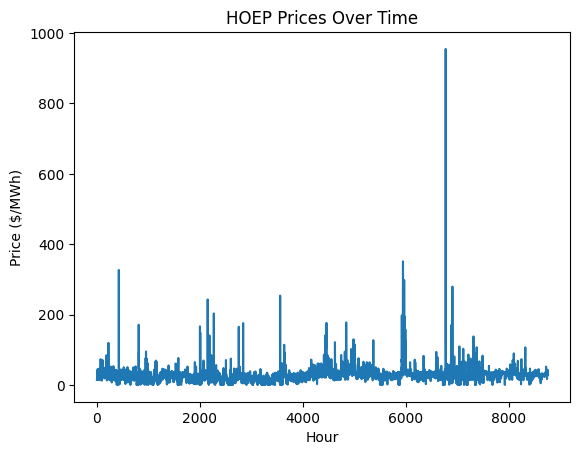

Total profit from energy arbitrage over the simulation period: $7184.37


In [6]:
# Parameters
battery_capacity = 4  # MWh
battery_charge_rate = 1  # MW/h, also discharge rate
battery_state = battery_capacity  # Battery starts fully charged

# Combine all years of data into a single DataFrame
all_data = pd.DataFrame()
for file_path in file_paths.values():
    yearly_data = pd.read_csv(file_path, skiprows=2)
    yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
    yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
    yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
    all_data = pd.concat([all_data, yearly_data])

# Clean the data and reset index
all_data.reset_index(drop=True, inplace=True)
all_data.dropna(subset=['HOEP'], inplace=True)

# Simulation
profit = 0
energy_stored = 0
hourly_hoep = all_data['HOEP'].values
last_price = hourly_hoep[0]

for current_price in hourly_hoep[1:]:
    # Check if there is a reversal in price trend
    if current_price > last_price and energy_stored > 0:
        # Price is going up, sell energy (if previously bought)
        energy_to_sell = min(battery_charge_rate, energy_stored)
        energy_stored -= energy_to_sell
        profit += energy_to_sell * current_price
    elif current_price < last_price and energy_stored < battery_capacity:
        # Price is going down, buy energy (if capacity is available)
        energy_to_buy = min(battery_charge_rate, battery_capacity - energy_stored)
        energy_stored += energy_to_buy
        profit -= energy_to_buy * current_price

    # Update the last price for the next iteration
    last_price = current_price

# Plotting the results
plt.plot(all_data['HOEP'])
plt.title('HOEP Prices Over Time')
plt.xlabel('Hour')
plt.ylabel('Price ($/MWh)')
plt.show()

print(f"Total profit from energy arbitrage over the simulation period: ${profit:.2f}")

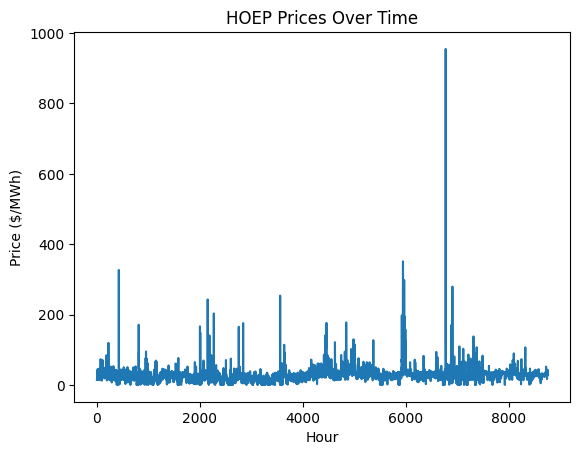

Total profit from energy arbitrage over the simulation period: $517.70
Remaining battery health after simulation: 0.00%


In [7]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the file paths


# Parameters
battery_capacity = 4  # MWh initial
battery_charge_rate = 1  # MW/h, also discharge rate
battery_health = 1.0  # initial health at 100%

# Function to model battery degradation
def update_battery_health(current_health, cycles):
    return current_health * (1 - 0.0001 * cycles)  # Example degradation model

# Combine all years of data into a single DataFrame
all_data = pd.DataFrame()
for file_path in file_paths.values():
    yearly_data = pd.read_csv(file_path, skiprows=2)
    yearly_data.columns = ['Date', 'Hour', 'HOEP', 'Hour 1 Predispatch', 'Hour 2 Predispatch', 'Hour 3 Predispatch', 'OR 10 Min Sync', 'OR 10 Min non-sync', 'OR 30 Min']
    yearly_data = yearly_data[['Date', 'Hour', 'HOEP']]
    yearly_data = yearly_data[yearly_data['Hour'].apply(lambda x: x.isnumeric())]
    yearly_data['HOEP'] = pd.to_numeric(yearly_data['HOEP'], errors='coerce')
    all_data = pd.concat([all_data, yearly_data])

# Clean the data and reset index
all_data.reset_index(drop=True, inplace=True)
all_data.dropna(subset=['HOEP'], inplace=True)

# Simulation
profit = 0
energy_stored = 0
hourly_hoep = all_data['HOEP'].values
cycle_count = 0

for i in range(24, len(hourly_hoep)-1):
    current_capacity = battery_capacity * battery_health  # Adjust capacity based on battery health
    predicted_next_hour_price = np.mean(hourly_hoep[i-24:i])
    current_price = hourly_hoep[i]

    if current_price < predicted_next_hour_price and energy_stored < current_capacity:
        # Buy energy to store
        energy_to_buy = min(battery_charge_rate, current_capacity - energy_stored)
        energy_stored += energy_to_buy
        profit -= energy_to_buy * current_price
        cycle_count += 1  # Increment cycle count on charge
    elif current_price > predicted_next_hour_price and energy_stored > 0:
        # Sell stored energy
        energy_to_sell = min(battery_charge_rate, energy_stored)
        energy_stored -= energy_to_sell
        profit += energy_to_sell * current_price
        cycle_count += 1  # Increment cycle count on discharge

    # Update battery health based on cycles
    battery_health = update_battery_health(battery_health, cycle_count)

# Plotting the results
plt.plot(all_data['HOEP'])
plt.title('HOEP Prices Over Time')
plt.xlabel('Hour')
plt.ylabel('Price ($/MWh)')
plt.show()

print(f"Total profit from energy arbitrage over the simulation period: ${profit:.2f}")
print(f"Remaining battery health after simulation: {battery_health*100:.2f}%")


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

# Load price data, ensure all_data is correctly defined
hourly_prices = all_data['HOEP'].values

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Initial conditions
initial_capacity = 4  # MWh

# Dictionary to hold profits for each cycle type
profits = {}

def simulate_daily_cycling(capacity_func, prices, initial_capacity):
    daily_profit = 0
    cycle_count = 0
    days = len(prices) // 24  # Assuming prices are hourly and we have complete days

    for day in range(days):
        daily_prices = prices[day*24:(day+1)*24]
        if len(daily_prices) < 24:
            continue  # Skip incomplete days

        # Determine the lowest and highest price hours
        min_price_hour = np.argmin(daily_prices)
        max_price_hour = np.argmax(daily_prices)

        # Current capacity based on cycles done so far
        current_capacity = capacity_func(cycle_count) * initial_capacity
        cycle_count += 1  # Each day counts as one cycle

        # Calculate profit from the chosen strategy
        buy_price = daily_prices[min_price_hour]
        sell_price = daily_prices[max_price_hour]
        # Assume the battery can fully charge and discharge within these hours
        daily_profit += (sell_price - buy_price) * current_capacity

    return daily_profit

# Run the simulation for each degradation model and plot results
for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100  # Convert percentages to fraction of initial capacity

    # Create a linear interpolation function for battery capacity
    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")

    # Extract model basename
    basename = os.path.basename(file_path).replace('.csv', '')
    
    # Simulate and store the result
    profits[basename] = simulate_daily_cycling(capacity_func, hourly_prices, initial_capacity)

# Display results
for cycle_type, profit in profits.items():
    print(f"{cycle_type}: ${profit:.2f}")


100to25: $63498.54
100to40: $64046.52
100to50: $64298.88
75to25: $64570.20
75to45: $65070.29
75to65: $65524.01
85to25: $64397.53


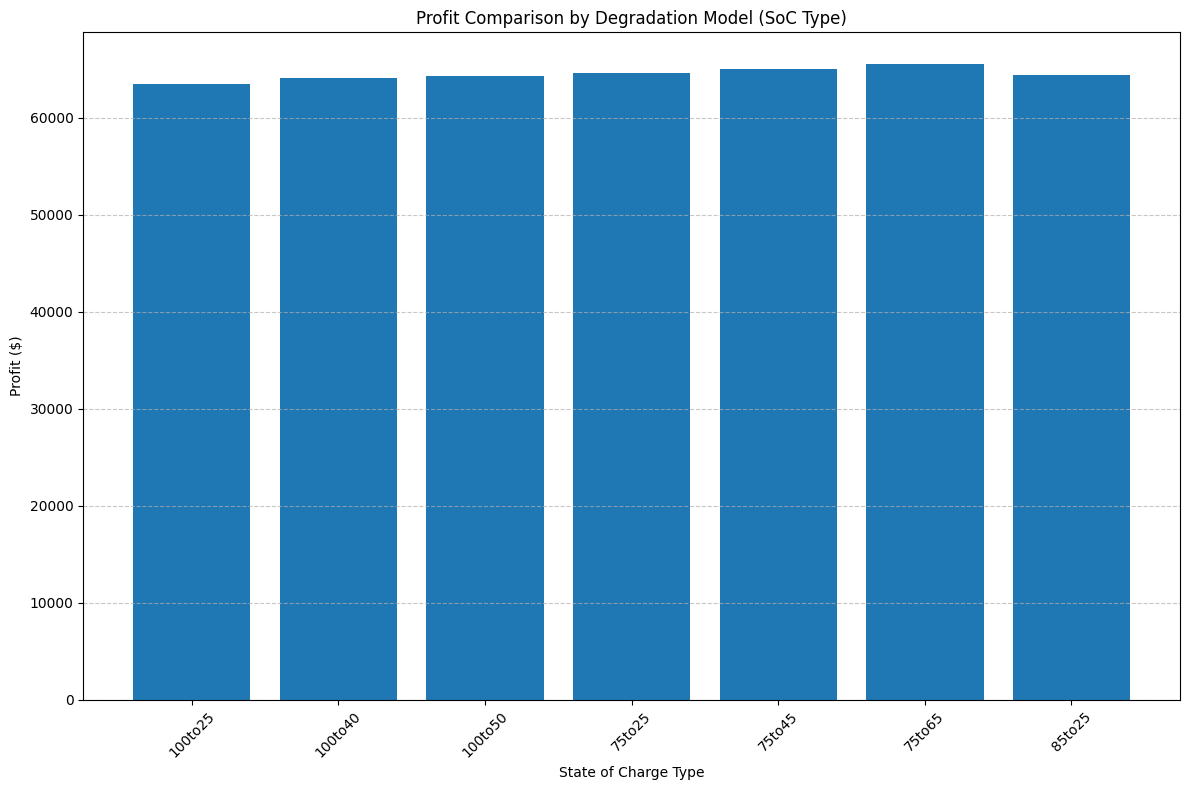

In [9]:
# Extract SoC types and corresponding profits for plotting
soc_types = list(profits.keys())
profit_values = list(profits.values())

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.bar(soc_types, profit_values)

# Add titles and labels
plt.title('Profit Comparison by Degradation Model (SoC Type)')
plt.xlabel('State of Charge Type')
plt.ylabel('Profit ($)')
plt.xticks(rotation=45)  # Rotate labels to prevent overlap
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

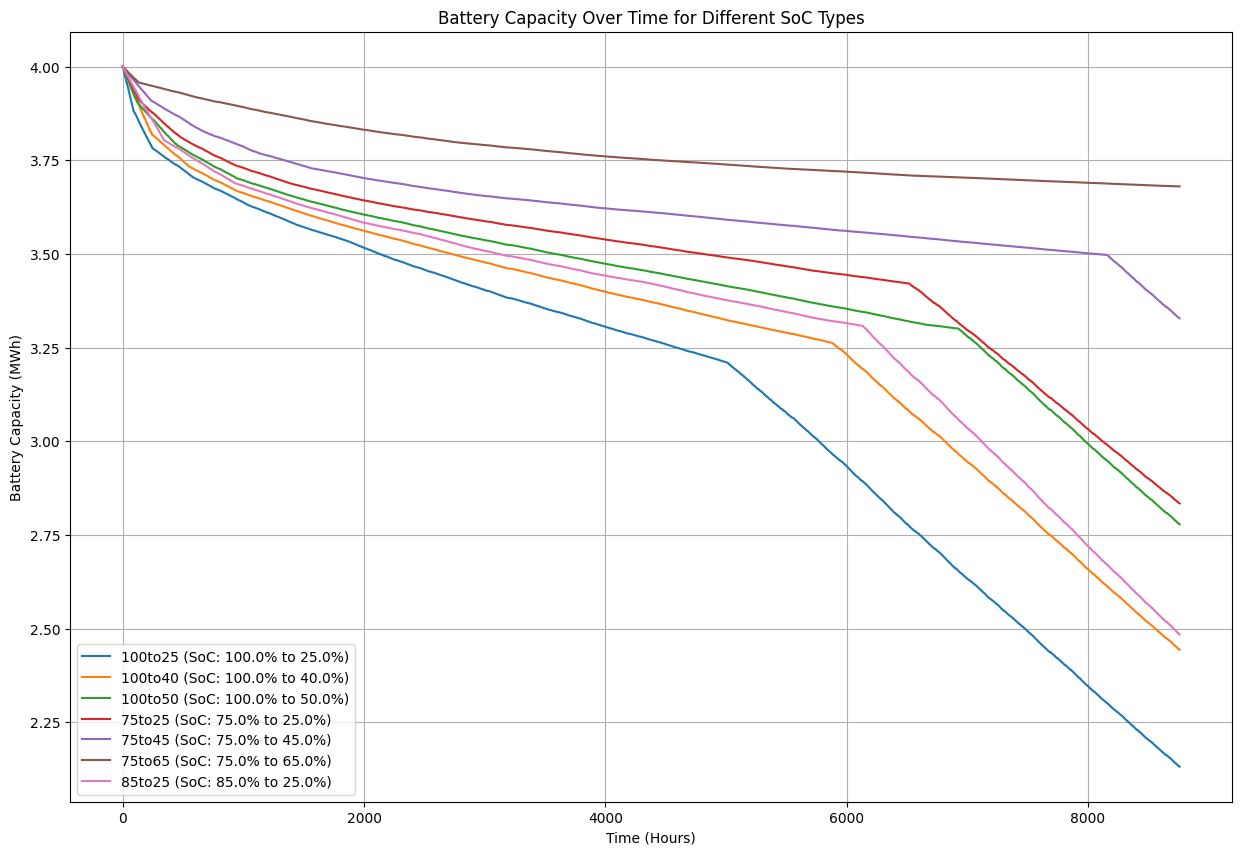

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.interpolate import interp1d

# Load the price data
hourly_prices = all_data['HOEP'].values  # Make sure to define 'all_data' with hourly price data

# Directory containing degradation models
folder_path = './Battery-cycles'
file_paths = glob.glob(os.path.join(folder_path, '*.csv'))

# Initial conditions
initial_capacity = 4  # MWh
charge_rate = 1  # MW/h
discharge_rate = 1  # MW/h

# Function to simulate energy arbitrage and track capacity
def simulate_and_track_capacity(capacity_func, prices, initial_capacity, charge_rate, discharge_rate, min_charge_level, max_charge_level):
    energy_stored = 0
    cycle_count = 0
    capacities = [initial_capacity]  # Track capacity over time

    for i in range(1, len(prices)):
        current_capacity = capacity_func(cycle_count) * initial_capacity
        min_allowed_energy = current_capacity * min_charge_level
        max_allowed_energy = current_capacity * max_charge_level
        
        predicted_next_price = prices[i]
        current_price = prices[i-1]

        if current_price < predicted_next_price and energy_stored < max_allowed_energy:
            energy_to_charge = min(charge_rate, max_allowed_energy - energy_stored)
            energy_stored += energy_to_charge
            cycle_count += 1
        elif current_price > predicted_next_price and energy_stored > min_allowed_energy:
            energy_to_sell = min(discharge_rate, energy_stored - min_allowed_energy)
            energy_stored -= energy_to_sell
            cycle_count += 1

        capacities.append(current_capacity)

    return capacities

# Run the simulation for each degradation model and plot the results
plt.figure(figsize=(15, 10))

for file_path in file_paths:
    data = pd.read_csv(file_path, header=None)
    sorted_data = data.sort_values(by=0)
    cycle_numbers = sorted_data[0].values
    capacities = sorted_data[1].values / 100

    capacity_func = interp1d(cycle_numbers, capacities, bounds_error=False, fill_value="extrapolate")
    basename = os.path.basename(file_path).replace('.csv', '')
    max_charge_level, min_charge_level = map(int, basename.split('to'))
    min_charge_level /= 100
    max_charge_level /= 100

    tracked_capacities = simulate_and_track_capacity(capacity_func, hourly_prices, initial_capacity, charge_rate, discharge_rate, min_charge_level, max_charge_level)
    plt.plot(tracked_capacities, label=f'{basename} (SoC: {max_charge_level*100}% to {min_charge_level*100}%)')

plt.title('Battery Capacity Over Time for Different SoC Types')
plt.xlabel('Time (Hours)')
plt.ylabel('Battery Capacity (MWh)')
plt.legend()
plt.grid(True)
plt.show()
